# Digital Image Pre-Processing

## Preliminaries

### Imports

In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
import skimage.io as io
import skimage.color as  color
import skimage.draw as draw
import skimage.transform as transform
import skimage.filters as filters
import skimage.measure as measure
import skimage.util as util

import scipy.ndimage as ndimage

import sys
sys.path.append("../../")
from E4525_ML import mnist

%matplotlib inline

### Data Directory

In [2]:
raw_data_dir="../../raw"
data_dir="../../data/digits"
if not(os.path.exists(data_dir)):
    os.mkdir(data_dir)

### Read Data

In [3]:
raw_image=skimage.io.imread(raw_data_dir+"/digits.jpg")
raw_image.shape

(3024, 4032, 3)

In [4]:
gray_image=color.rgb2gray(raw_image)

In [5]:
gray_image.shape

(3024, 4032)

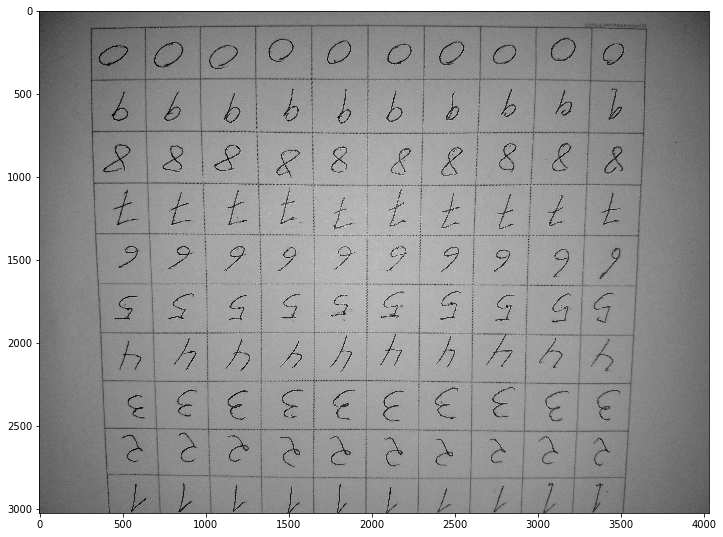

In [6]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(gray_image,cmap='gray')

## Basic (Information Preserving) Image Processing

### 180 deg Rotation

In [7]:
rotated_image=transform.rotate(gray_image,180)

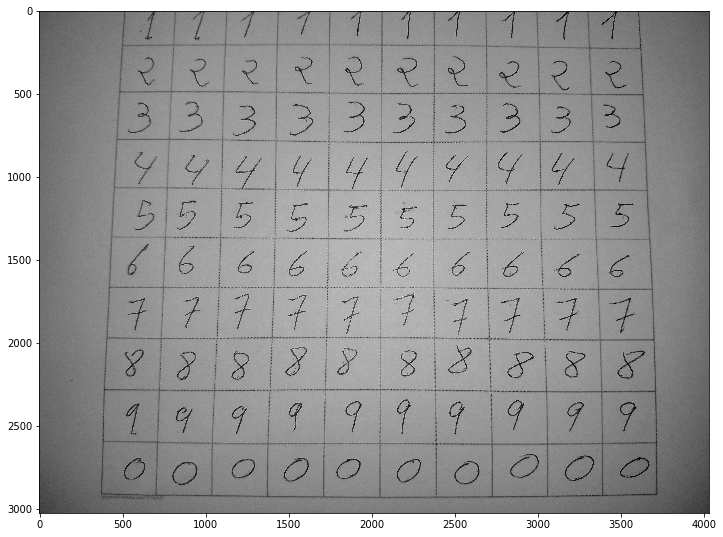

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(rotated_image,cmap='gray',interpolation="nearest")

### Invert Gray Scale

In [9]:
rotated_image=1-rotated_image

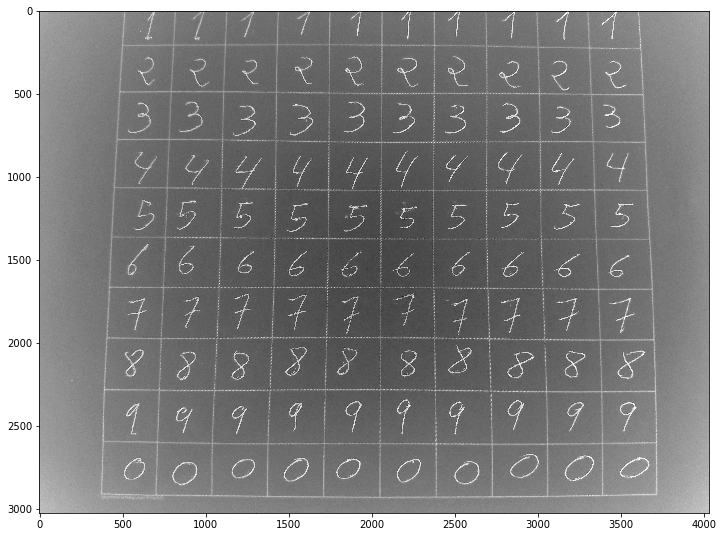

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(rotated_image,cmap='gray',interpolation="nearest")

## Correct Camara point of view 

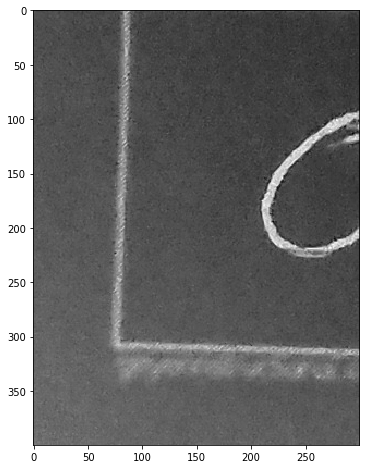

In [11]:
slice1=rotated_image[2600:3000,300:600]
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(slice1,cmap='gray',interpolation="nearest")

### Left Bottom corner coordiates

In [12]:
Radius=20

In [13]:
lb_corner=[2600+307,300+76]
lb_corner_c=draw.circle(lb_corner[0],lb_corner[1],Radius)
marked_image=np.copy(rotated_image)
marked_image[lb_corner_c]=1

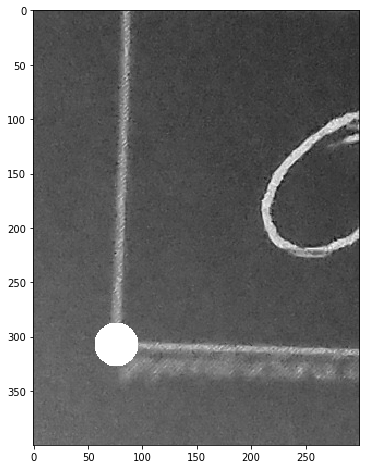

In [14]:
marked_slice=marked_image[2600:3000,300:600]
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(marked_slice,cmap='gray',interpolation="nearest")

### Left Top Corner

In [15]:
lt_corner=[0,517]
lt_corner_c=draw.circle(lt_corner[0],lt_corner[1],Radius)
marked_image=np.copy(rotated_image)
marked_image[lt_corner_c]=1

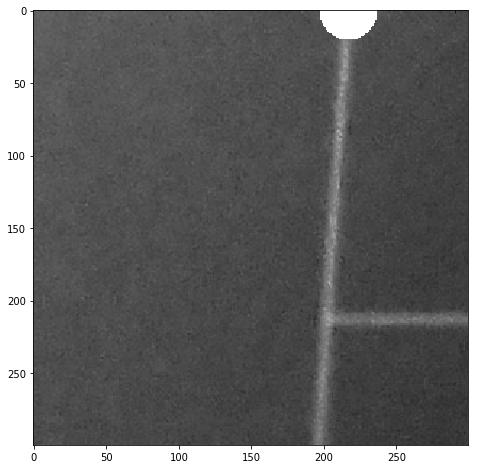

In [16]:
marked_slice=marked_image[0:300,300:600]
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(marked_slice,cmap='gray',interpolation="nearest")

### Right Bottom  Corner

In [17]:
rb_corner=[2600+310,3600+117]
rb_corner_c=draw.circle(rb_corner[0],rb_corner[1],Radius)
marked_image=np.copy(rotated_image)
marked_image[rb_corner_c]=1

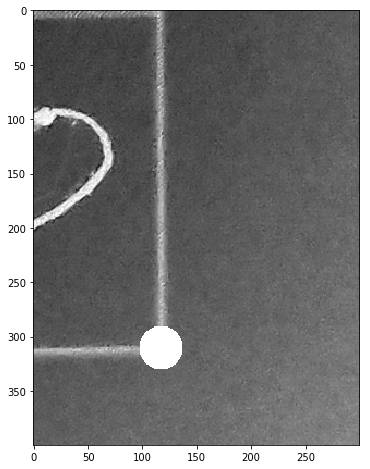

In [18]:
marked_slice=marked_image[2600:3000,3600:3900]
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(marked_slice,cmap='gray',interpolation="nearest")

### Right Top  Corner

In [19]:
rt_corner=[0,3600+8]
rt_corner_c=draw.circle(rt_corner[0],rt_corner[1],Radius)
marked_image=np.copy(rotated_image)
marked_image[rt_corner_c]=1

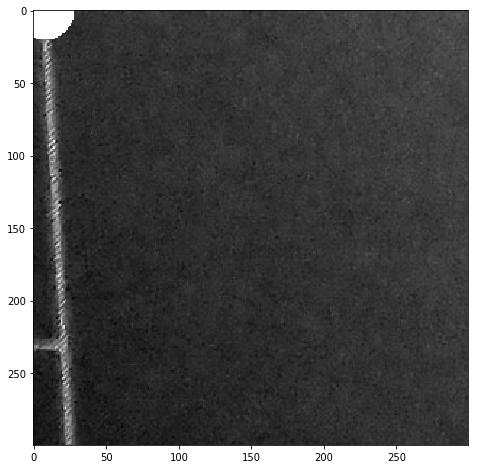

In [20]:
marked_slice=marked_image[0:300,3600:3900]
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(marked_slice,cmap='gray',interpolation="nearest")

### All four corners together

In [21]:
marked_image=np.copy(rotated_image)
marked_image[lb_corner_c]=1
marked_image[lt_corner_c]=1
marked_image[rt_corner_c]=1
marked_image[rb_corner_c]=1

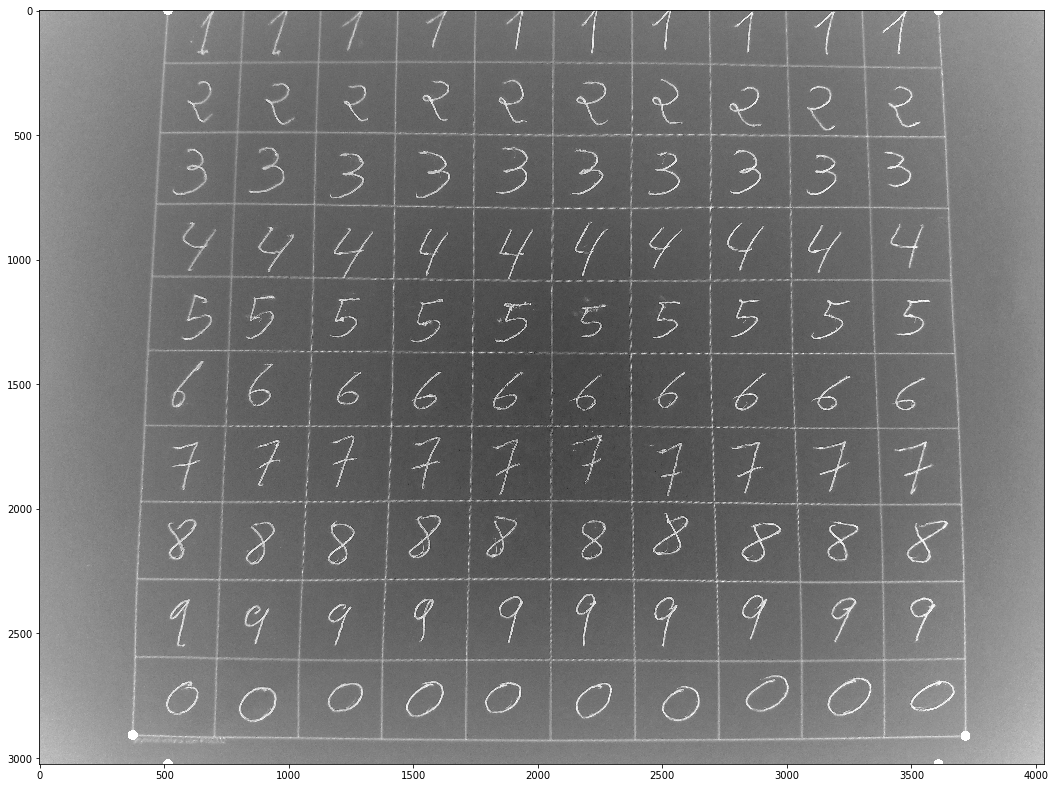

In [22]:
fig, ax = plt.subplots(figsize=(18, 18))

ax.imshow(marked_image,cmap='gray',interpolation="nearest")

### Apply Projective Transformation

In [23]:
R,C=rotated_image.shape
R,C

(3024, 4032)

In [24]:
Cn=4000
Rn=R/C*Cn # preserve aspect ratio
Rn,Cn

(3000.0, 4000)

In [25]:
src = np.array([[0,0],[Cn,0],[0,Rn],[Cn,Rn]])
src

array([[   0.,    0.],
       [4000.,    0.],
       [   0., 3000.],
       [4000., 3000.]])

In [26]:
dst = np.array([[lt_corner[1],lt_corner[0]],
                [rt_corner[1],rt_corner[0]],
                [lb_corner[1],lb_corner[0]],
                [rb_corner[1],rb_corner[0]],
               ])
dst

array([[ 517,    0],
       [3608,    0],
       [ 376, 2907],
       [3717, 2910]])

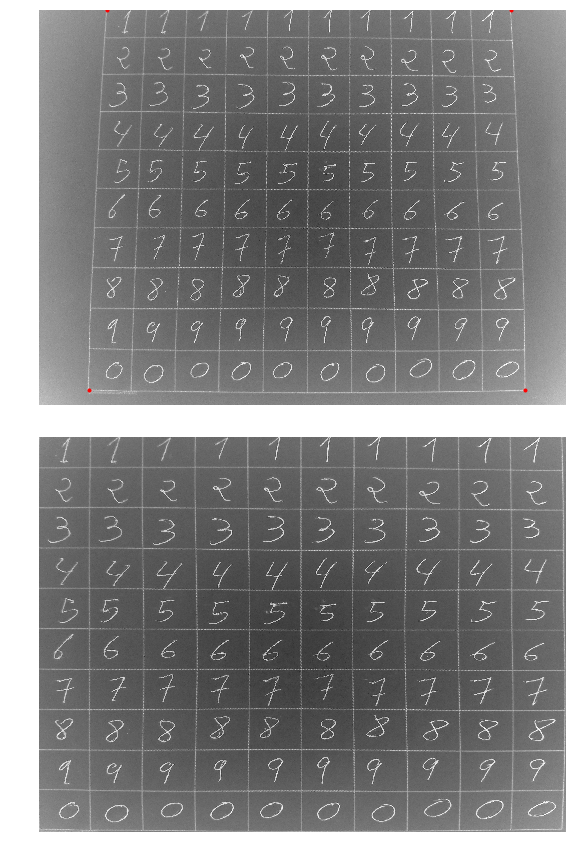

In [27]:
tform3 = transform.ProjectiveTransform()
tform3.estimate(src,dst)
warped = transform.warp(rotated_image, tform3)

fig, ax = plt.subplots(nrows=2, figsize=(12, 12))

ax[0].imshow(rotated_image, cmap=plt.cm.gray)
ax[0].plot(dst[:, 0], dst[:, 1], '.r')
ax[1].imshow(warped, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Separate Digits

### Find Row coordinates

In [28]:
delta_row0=[9]*10
delta_row0[0]=0
delta_row0[1]=2
delta_row0[2]=4
delta_row0[9]=20
delta_row1=[30]*10
delta_row1[0]=90
delta_row1[1]=70
delta_row1[2]=55
delta_row1[3]=50
delta_row1[4]=40


In [29]:
DR=Rn/10
rslices=[]
for idx in range(10):
    r=DR*idx
    r0=int(r+delta_row0[idx])
    r1=int(r+DR-delta_row1[idx])
    print(r0,r1)
    s=slice(r0,r1,1)
    sliced_image=warped[s]
    rslices.append(sliced_image)

0 210
302 530
604 845
909 1150
1209 1460
1509 1770
1809 2070
2109 2370
2409 2670
2720 2970


(-0.5, 4031.5, 250.5, -0.5)

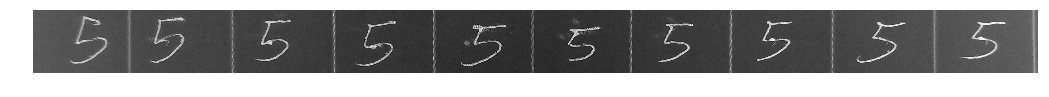

In [30]:
row=4
fig, ax = plt.subplots(figsize=(18, 18))

ax.imshow(rslices[row],cmap='gray',interpolation="nearest")
ax.axis('off')


### Find Column Coordinates 

In [31]:

delta_col0=[30]*10
delta_col1=[15]*10

DC=Cn/10
cslices=[]
for idx in range(10):
    c=DC*idx
    c0=int(c+delta_col0[idx])
    c1=int(c+DC-delta_col1[idx])
    print(c0,c1)
    s=slice(c0,c1,1)
    sliced_image=warped[:,s]
    cslices.append(sliced_image)

30 385
430 785
830 1185
1230 1585
1630 1985
2030 2385
2430 2785
2830 3185
3230 3585
3630 3985


(-0.5, 354.5, 3023.5, -0.5)

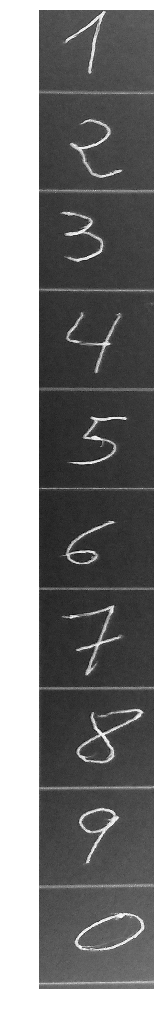

In [32]:
col=9
fig, ax = plt.subplots(figsize=(18, 18))

ax.imshow(cslices[col],cmap='gray',interpolation="nearest")
ax.axis('off')

### Separate Raw Digits and Save

In [33]:
raw_digits=[]
labels=[]
for r in range(10):
    r_slice=slice(int(DR*r+delta_row0[r]),int(DR*(r+1)-delta_row1[r]),1)
    label=(r+1 ) % 10
    for c in range(10):
        c_slice=slice(int(DC*c+delta_col0[c]),int(DC*(c+1)-delta_col1[c]),1)
        raw_digit=np.copy(warped[r_slice,c_slice])
        raw_digits.append(raw_digit)
        labels.append(label)

(-0.5, 354.5, 240.5, -0.5)

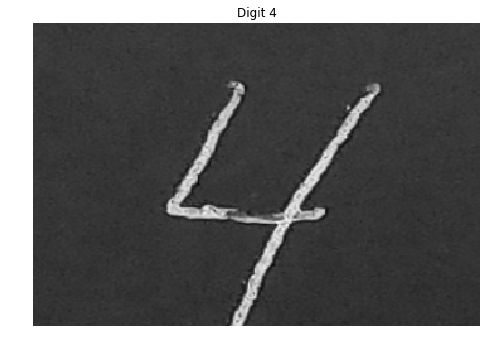

In [34]:
idx=34

fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(raw_digits[idx],cmap='gray',interpolation="nearest")
ax.set_title("Digit {0}".format(labels[idx]))
ax.axis('off')

In [35]:
raw_filename=data_dir+"/raw_digits.p"
file=open(raw_filename,"wb")
pickle.dump((raw_digits,labels),file)

## Threshold images

In [36]:
# This line does not work on oldish versions of skimage
#fig, ax =filters.try_all_threshold(raw_digits[57], figsize=(10, 8), verbose=False)
#plt.show()

In [37]:
thresholded_digits=[]
for digit in raw_digits:
    threshold=filters.threshold_isodata(digit)
    img=digit>threshold
    thresholded_digits.append(img)

In [38]:
len(thresholded_digits),thresholded_digits[0].shape

(100, (210, 355))

(-0.5, 354.5, 240.5, -0.5)

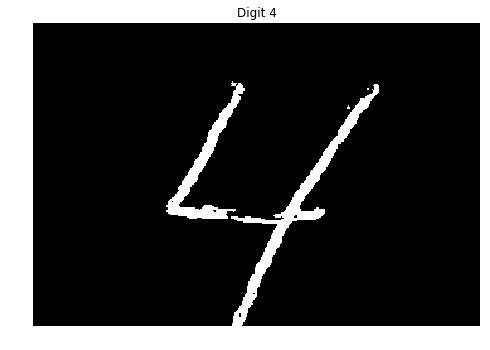

In [39]:
idx=34

fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(thresholded_digits[idx],cmap='gray',interpolation="nearest")
ax.set_title("Digit {0}".format(labels[idx]))
ax.axis('off')

In [40]:
raw_filename=data_dir+"/thresholded_digits.p"
file=open(raw_filename,"wb")
pickle.dump((thresholded_digits,labels),file)

## Position Image

### Center Image

In [41]:
from skimage.transform import SimilarityTransform

In [42]:
idx=99
img=thresholded_digits[idx]


In [43]:
R0,C0=ndimage.center_of_mass(img)
dR,dC=(img.shape[0]/2- R0 , img.shape[1]/2-C0)

In [44]:
print(img.shape[0]/2,img.shape[1]/2)
print(R0,C0)
print(dR,dC)

125.0 177.5
127.42960559161259 220.53744383424862
-2.429605591612585 -43.03744383424862


In [45]:
tform = SimilarityTransform(translation=(-dC,-dR))
translated=transform.warp(img, tform)

In [46]:
ndimage.center_of_mass(translated)

(124.99999999999999, 177.5)

Text(0.5,1,'Translated Digit 0')

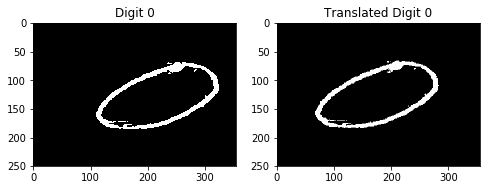

In [47]:

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(8, 8))

ax1.imshow(img,cmap='gray',interpolation="nearest")
ax1.set_title("Digit {0}".format(labels[idx]))
#ax1.axis('off')
ax2.imshow(translated,cmap='gray',interpolation="nearest")
ax2.set_title("Translated Digit {0}".format(labels[idx]))
#ax2.axis('off')

In [48]:
def center_image(image):
    R0,C0=ndimage.center_of_mass(image)
    dR,dC=(image.shape[0]/2- R0 , image.shape[1]/2-C0)
    tform = SimilarityTransform(translation=(-dC,-dR))
    translated=transform.warp(image, tform)
    return translated

### Compute Bounding Box

In [49]:
idx=99

In [50]:
image_labels=measure.label(thresholded_digits[idx])

In [51]:
props=measure.regionprops(image_labels)

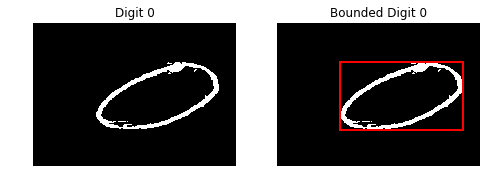

In [52]:

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(8, 8))

ax1.imshow(thresholded_digits[idx],cmap='gray',interpolation="nearest")
ax1.set_title("Digit {0}".format(labels[idx]))
ax1.axis('off')
ax2.imshow(thresholded_digits[idx],cmap='gray',interpolation="nearest")
ax2.set_title("Bounded Digit {0}".format(labels[idx]))
ax2.axis('off')

min_row=10000000
min_col=10000000
max_row=-1
max_col=-1
for region in props:
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        min_row=min(min_row,minr)
        min_col=min(min_col,minc)
        max_row=max(max_row,maxr)
        max_col=max(max_col,maxc)
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=1)
        ax2.add_patch(rect)
rect = mpatches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                                  fill=False, edgecolor='red', linewidth=2)
ax2.add_patch(rect)

In [53]:
def compute_bounding_box(image):
    image_labels=measure.label(image)
    props=measure.regionprops(image_labels)
    min_row=10000000
    min_col=10000000
    max_row=-1
    max_col=-1
    for region in props:
        # take regions with large enough areas
        if region.area >= 100:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            min_row=min(min_row,minr)
            min_col=min(min_col,minc)
            max_row=max(max_row,maxr)
            max_col=max(max_col,maxc)
    return min_row,min_col,max_row,max_col

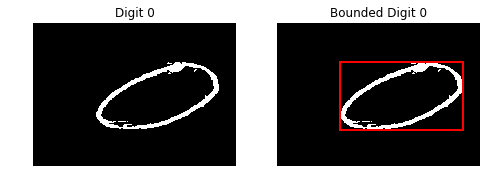

In [54]:
idx=99
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(8, 8))

ax1.imshow(thresholded_digits[idx],cmap='gray',interpolation="nearest")
ax1.set_title("Digit {0}".format(labels[idx]))
ax1.axis('off')
ax2.imshow(thresholded_digits[idx],cmap='gray',interpolation="nearest")
ax2.set_title("Bounded Digit {0}".format(labels[idx]))
ax2.axis('off')
min_row,min_col,max_row,max_col=compute_bounding_box(thresholded_digits[idx])

rect = mpatches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                                  fill=False, edgecolor='red', linewidth=2)
ax2.add_patch(rect)

### Crop and Scale

In [55]:
def crop_and_scale(image):
    min_row,min_col,max_row,max_col=compute_bounding_box(image)
    drows=(max_row-min_row)
    dcols=(max_col-min_col)
    side=max(drows,dcols)
    row_slice=slice(min_row,max_row,1)
    col_slice=slice(min_col,max_col,1)
    img=image[row_slice,col_slice]
    img=util.pad(img,((0,side-drows),(0,side-dcols)),mode="constant",constant_values=0)
    img=transform.rescale(img,200/side,mode="constant")
    img=util.pad(img,((40,40),(40,40)),mode="constant",constant_values=0)
    img=center_image(img)
    return img

(-0.5, 279.5, 279.5, -0.5)

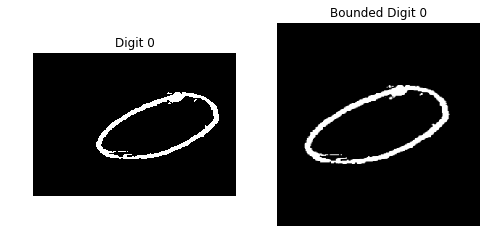

In [56]:
idx=99
img2=crop_and_scale(thresholded_digits[idx])
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(8, 8))

ax1.imshow(thresholded_digits[idx],cmap='gray',interpolation="nearest")
ax1.set_title("Digit {0}".format(labels[idx]))
ax1.axis('off')
ax2.imshow(img2,cmap='gray',interpolation="nearest")
ax2.set_title("Bounded Digit {0}".format(labels[idx]))
ax2.axis('off')


In [57]:
centered_digits=[]
for digit in thresholded_digits:
    centered_digits.append(crop_and_scale(digit))

In [58]:
raw_filename=data_dir+"/centered_digits.p"
file=open(raw_filename,"wb")
pickle.dump((centered_digits,labels),file)

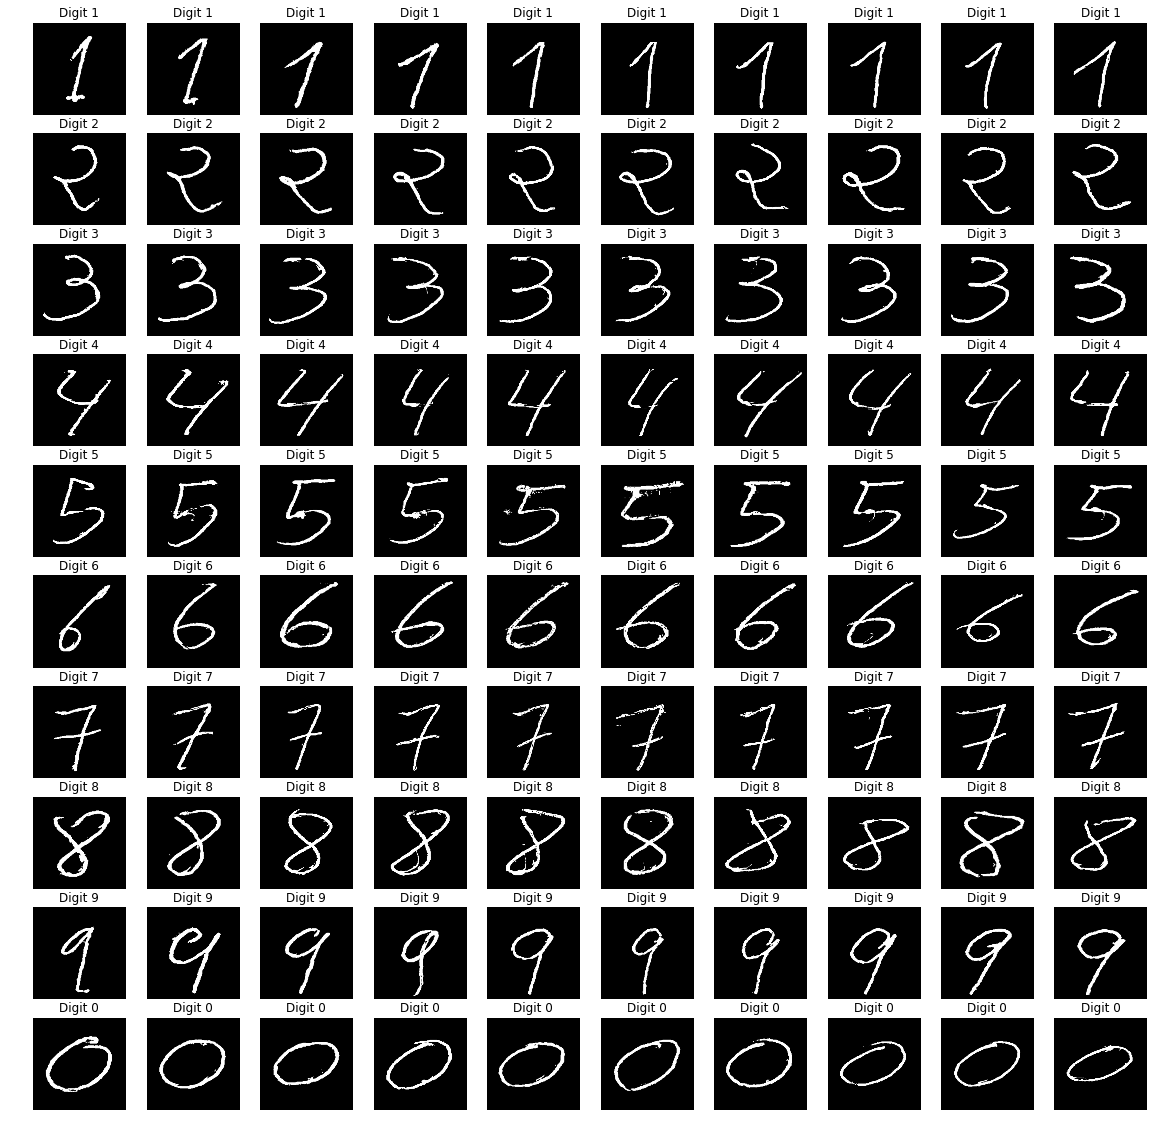

In [59]:

fig, axes = plt.subplots(nrows=10,ncols=10,figsize=(20, 20))
for idx in range(len(centered_digits)):
        r = idx//10
        c = idx % 10
        img=centered_digits[idx]
        axes[r,c].imshow(img,cmap='gray',interpolation="nearest")
        axes[r,c].set_title("Digit {0}".format(labels[idx]))
        axes[r,c].axis('off')


## Downsample

In [60]:
downscaled_digits=[]
for digit in centered_digits:
     img=transform.resize(digit,(28,28),mode="constant")
     M=img.max()
     img2=np.sqrt(np.maximum(img,0)/M)
     downscaled_digits.append(img2)
downscaled_digits=np.array(downscaled_digits)

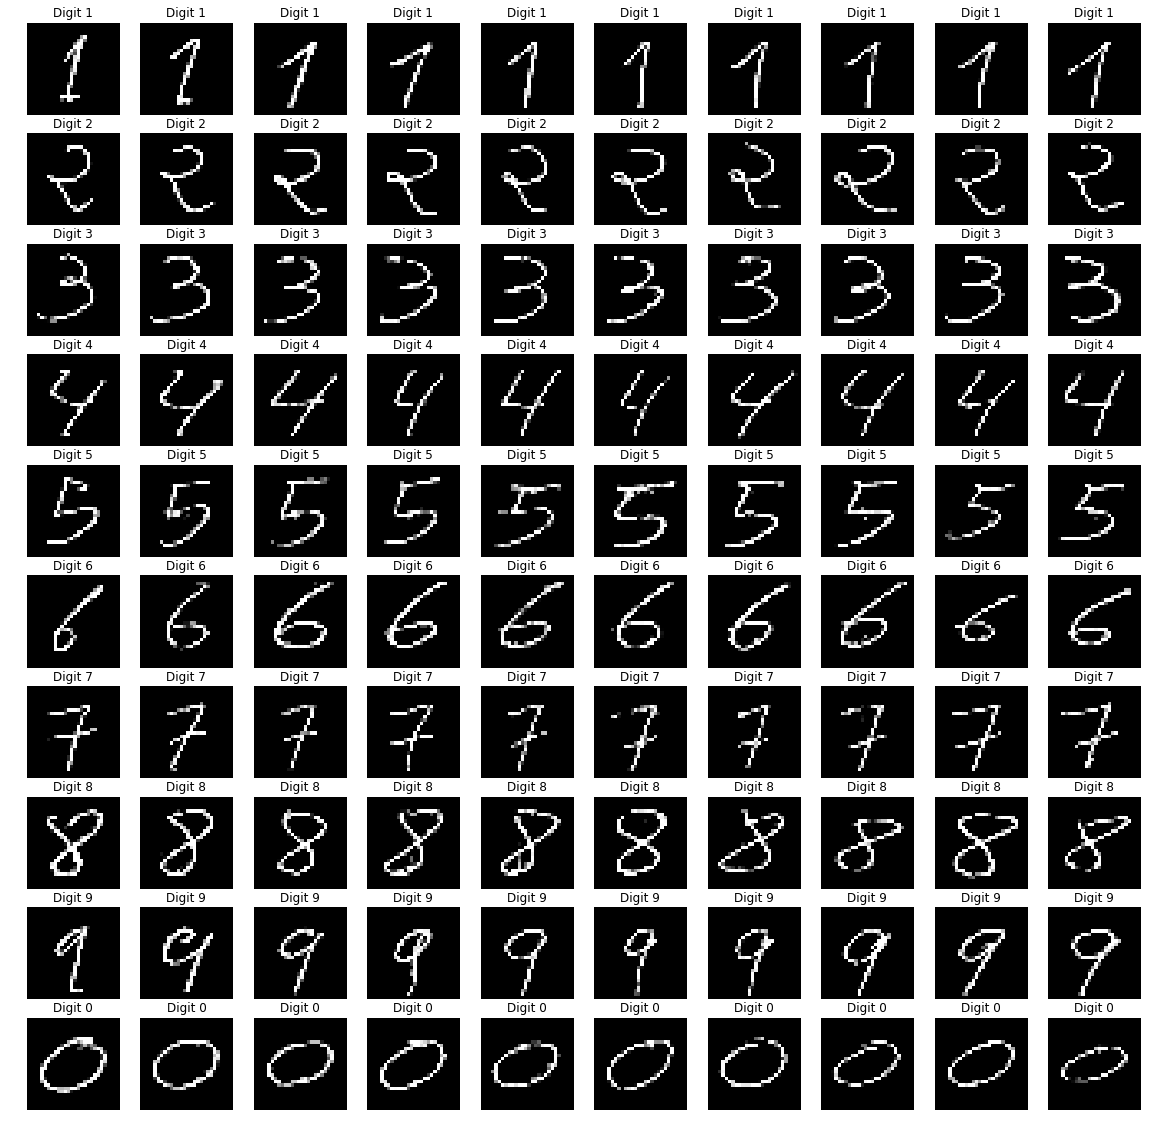

In [61]:
fig, axes = plt.subplots(nrows=10,ncols=10,figsize=(20, 20))
for idx in range(len(downscaled_digits)):
        r = idx//10
        c = idx % 10
        img=downscaled_digits[idx]
        axes[r,c].imshow(img,cmap='gray',interpolation="nearest")
        axes[r,c].set_title("Digit {0}".format(labels[idx]))
        axes[r,c].axis('off')

In [62]:
raw_filename=data_dir+"/digits.p"
file=open(raw_filename,"wb")
pickle.dump((downscaled_digits,labels),file)

### Antialias downscaling

In [63]:
from PIL import Image

In [64]:
antialiased_digits=[]
for digit in centered_digits:
    img=Image.fromarray(digit)
    img2=np.array(img.resize((28,28),Image.ANTIALIAS))
    M=img2.max()
    img3=np.sqrt(np.maximum(img2,0)/M)
    antialiased_digits.append(img3)
antialiased_digits=np.array(antialiased_digits)

In [65]:
raw_filename=data_dir+"/antialiased_digits.p"
file=open(raw_filename,"wb")
pickle.dump((antialiased_digits,labels),file)

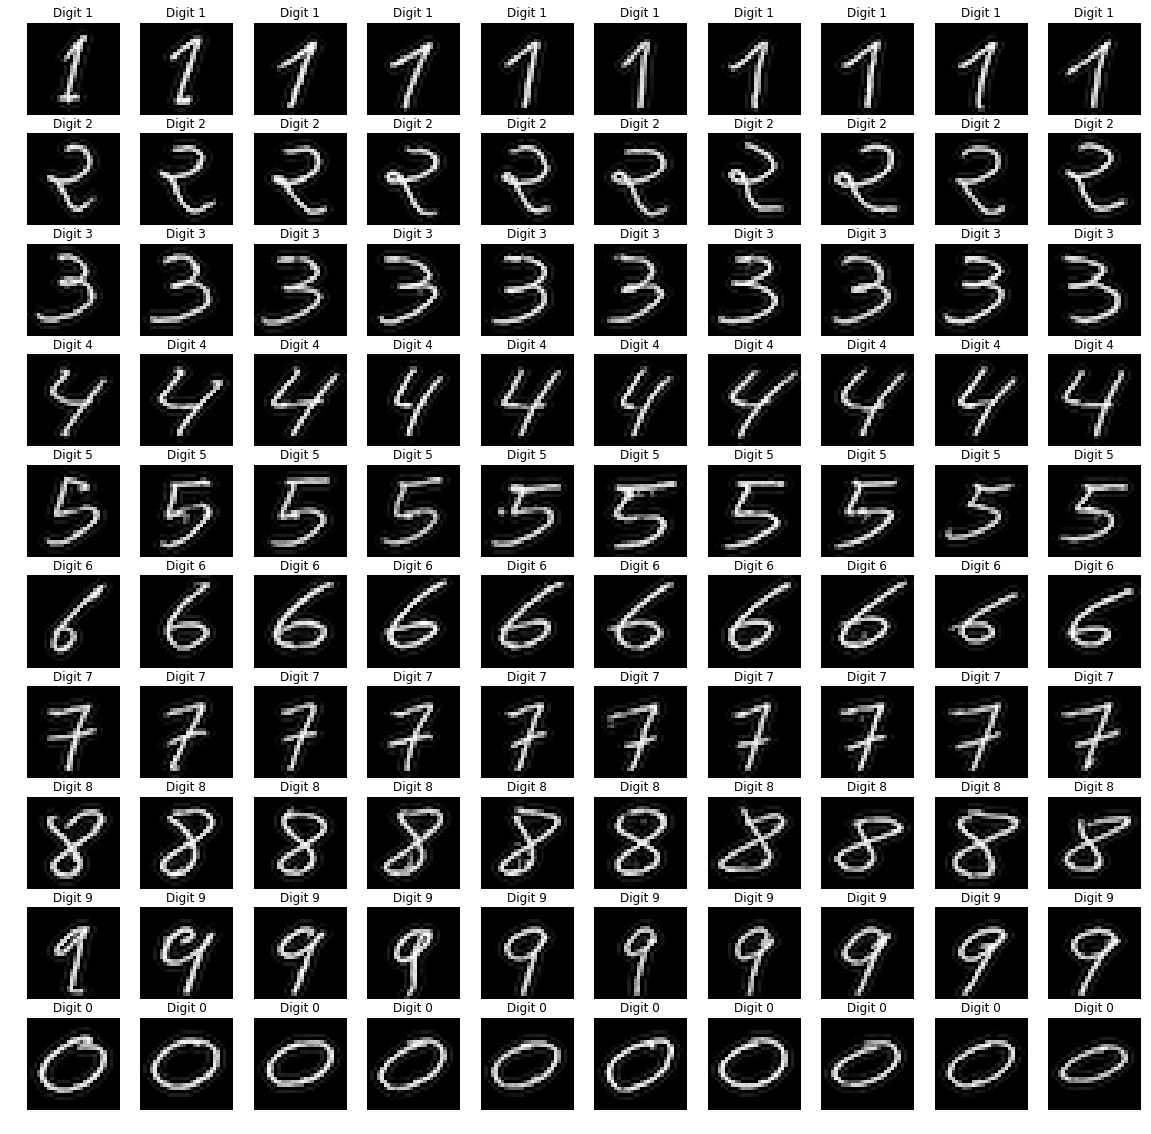

In [66]:
fig, axes = plt.subplots(nrows=10,ncols=10,figsize=(20, 20))
for idx in range(len(antialiased_digits)):
        r = idx//10
        c = idx % 10
        img=antialiased_digits[idx]
        axes[r,c].imshow(img,cmap='gray',interpolation="nearest")
        axes[r,c].set_title("Digit {0}".format(labels[idx]))
        axes[r,c].axis('off')

### Visually compare to MNIST samples

In [67]:
mnist_data_dir=r"../../raw/MNIST/"
images_filename=mnist_data_dir+"train-images-idx3-ubyte.gz"
labels_filename=mnist_data_dir+"train-labels-idx1-ubyte.gz"


images=mnist.read_images(images_filename)
Y=mnist.read_labels(labels_filename)

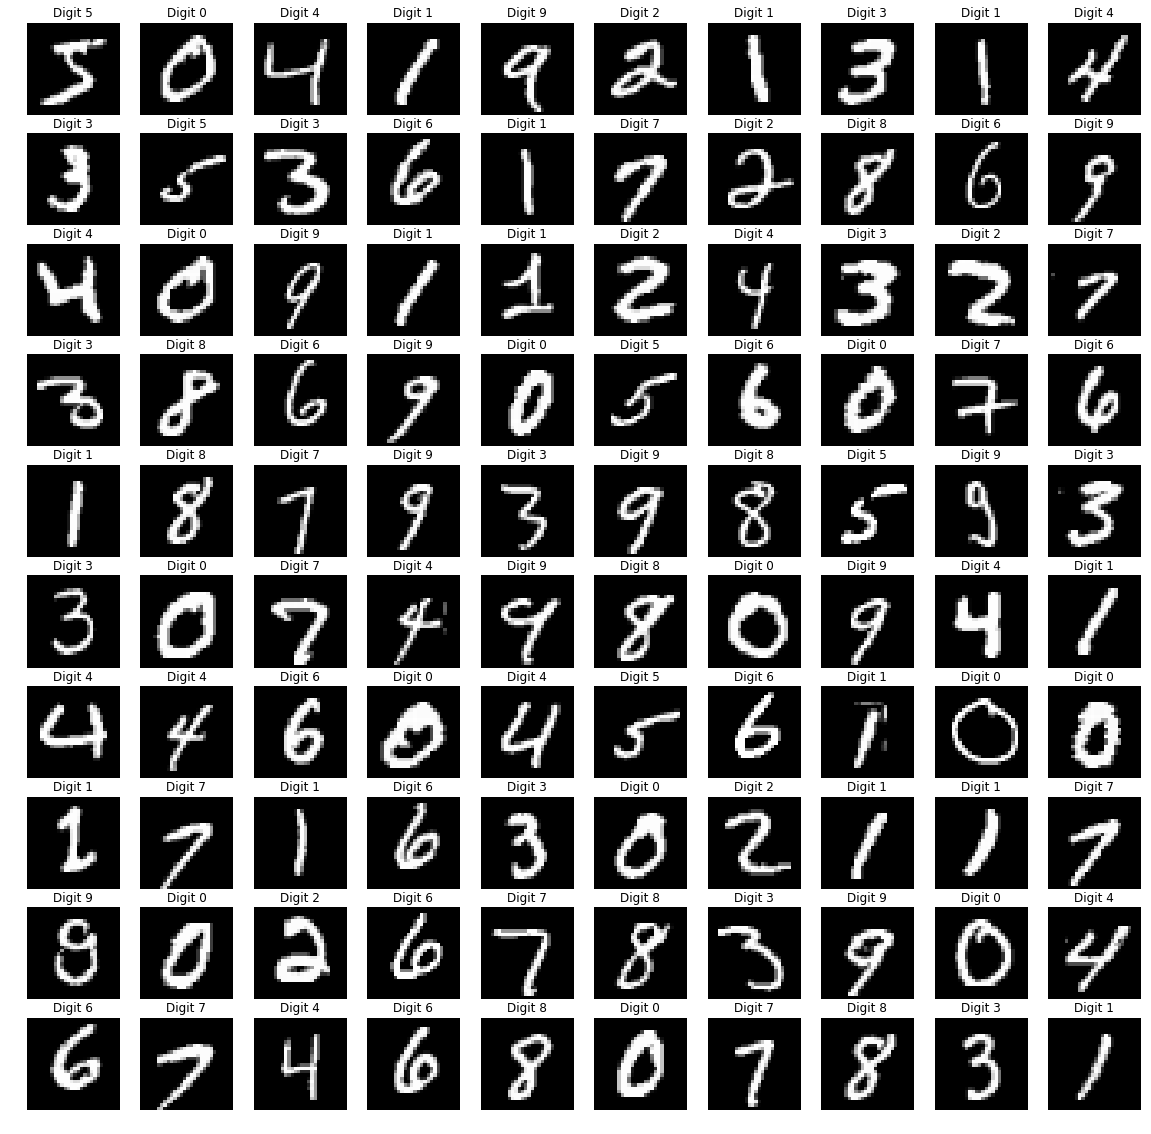

In [68]:
fig, axes = plt.subplots(nrows=10,ncols=10,figsize=(20, 20))
for idx in range(100):
        r = idx//10
        c = idx % 10
        img=images[idx]
        axes[r,c].imshow(img,cmap='gray',interpolation="nearest")
        axes[r,c].set_title("Digit {0}".format(Y[idx]))
        axes[r,c].axis('off')

### 